In [3]:
import copy
import dgl
import matplotlib
import matplotlib.cm as cm
import torch

from functools import partial
from IPython.display import SVG, display
from rdkit import Chem
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from dgllife.data import PubChemBioAssayAromaticity
from dgllife.model import load_pretrained
from dgllife.utils.featurizers import BaseAtomFeaturizer, ConcatFeaturizer, atom_type_one_hot, \
    atom_degree_one_hot, atom_formal_charge, atom_num_radical_electrons, \
    atom_hybridization_one_hot, atom_total_num_H_one_hot, BaseBondFeaturizer

Prepare the model, dataset and the features.

In [4]:
# Prepare featurization functions for atoms and bonds
def chirality(atom):
    try:
        return one_hot_encoding(atom.GetProp('_CIPCode'), ['R', 'S']) + \
               [atom.HasProp('_ChiralityPossible')]
    except:
        return [False, False] + [atom.HasProp('_ChiralityPossible')]

atom_featurizer = BaseAtomFeaturizer(featurizer_funcs={'hv': ConcatFeaturizer([
                                      partial(atom_type_one_hot, 
                                              allowable_set=['B', 'C', 'N', 'O', 'F', 'Si', 'P', 'S', 'Cl', 
                                                             'As', 'Se', 'Br', 'Te', 'I', 'At'],
                                              encode_unknown=True),
                                      partial(atom_degree_one_hot, allowable_set=list(range(6))),
                                      atom_formal_charge, atom_num_radical_electrons,
                                      partial(atom_hybridization_one_hot, encode_unknown=True),
                                      lambda atom: [0], # A placeholder for aromatic information,
                                      atom_total_num_H_one_hot, chirality])})
bond_featurizer = BaseBondFeaturizer({'he': lambda bond: [0 for _ in range(10)]})

dataset = PubChemBioAssayAromaticity(node_featurizer=atom_featurizer, edge_featurizer=bond_featurizer)
model = load_pretrained('AttentiveFP_Aromaticity').eval()

Processing dgl graphs from scratch...
Processing molecule 1000/3949
Processing molecule 2000/3949
Processing molecule 3000/3949
Pretrained model loaded


COc1ccc(C(CNC(=O)c2ccc(S(=O)(=O)Nc3ccccc3C)cc2)N2CCOCC2)cc1 Graph(num_nodes=36, num_edges=78,
      ndata_schemes={'hv': Scheme(shape=(39,), dtype=torch.float32)}
      edata_schemes={'he': Scheme(shape=(10,), dtype=torch.float32)})
torch.Size([36, 1])


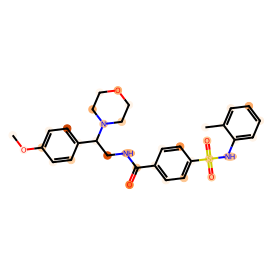

In [5]:
mol_id = 2019
timestep =  0
# def draw(mol_id, dataset, timestep):
# """Visualize the learned atom weights in readout.

# Parameters
# ----------
# mol_id : int
#     Index for the molecule to visualize in the dataset.
# dataset
# timestep : int
#     As the model has multiple rounds of readout, an additional
#     index is used to specify the round for the weights.
# """
#Get the weights from the model.
smiles, g, _, _ = dataset[mol_id]
print(smiles, g)
g = dgl.batch([g])
atom_feats, bond_feats = g.ndata.pop('hv'), g.edata.pop('he')
_, atom_weights = model(g, atom_feats, bond_feats, get_node_weight=True)
# normalization
assert timestep < len(atom_weights), 'Unexpected id for the readout round.'
atom_weights = atom_weights[timestep]
min_value = torch.min(atom_weights)
max_value = torch.max(atom_weights)
atom_weights = (atom_weights - min_value) / (max_value - min_value)
print(atom_weights.shape)
# Conver the weights to atom colors
norm = matplotlib.colors.Normalize(vmin=0, vmax=1.28)
cmap = cm.get_cmap('Oranges')
plt_colors = cm.ScalarMappable(norm=norm, cmap=cmap)
atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
# drawing molecule
mol = Chem.MolFromSmiles(smiles)
rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(280,280)
drawer.SetFontSize(1)
op = drawer.drawOptions()
print(mol)
mol = rdMolDraw2D.PrepareMolForDrawing(mol)
print(mol)
drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
highlightAtomColors=atom_colors)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg = svg.replace('svg:','')
display(SVG(svg))